In [1]:
import os
from convokit import Corpus, download
import re
from numpy import mean
from scipy import stats
import matplotlib.pyplot as plt


In [ ]:
corpus = Corpus(download("winning-args-corpus"))
utterance_ids = corpus.get_utterance_ids()

In [ ]:
#code to create two different lists, one with the iDs of successful
#comments, another with the iDs of unsuccessful ones

chal_s = []
chal_u = [] 

#want to only include non-OP comments
for iD in utterance_ids:
    if (
    corpus.get_utterance(iD).speaker.id
    != corpus.get_utterance(corpus.get_utterance(iD).root).speaker.id
    and corpus.get_utterance(iD).meta["success"] == 1
    ):
        chal_s.append(iD)
    elif (
    corpus.get_utterance(iD).speaker.id
    != corpus.get_utterance(corpus.get_utterance(iD).root).speaker.id
    and corpus.get_utterance(iD).meta["success"] == 0
    ):
        chal_u.append(iD)


In [7]:
utts = list(corpus.iter_utterances())

(
    succ_count, unsucc_count, 
    succ_word_count, succ_sentence_count, 
    unsucc_word_count, unsucc_sentence_count, 
    succ_fps_count, succ_sp_count, succ_fpp_count, 
    unsucc_fps_count, unsucc_sp_count, unsucc_fpp_count, 
    succ_link_count, unsucc_link_count
) = (0, 0, [], [], [], [], 0, 0, 0, 0, 0, 0, 0, 0)

fps_pronouns = {"i", "me", "my", "mine", "myself"}
sp_pronouns = {"you", "your", "yours"}
fpp_pronouns = {"we", "our", "us", "ours"}

def contains_link(text):
    url_pattern = r"https?://(?:www\.)?[^\s/$.?#].[^\s]*|www\.[^\s/$.?#].[^\s]*"
    return bool(re.search(url_pattern, text))

for utt in utts:
    if utt.conversation_id != utt.id and utt.speaker.id != corpus.get_utterance(utt.conversation_id).speaker.id:
        if utt.meta["success"] == 1:
            succ_count += 1
            succ_word_count.append(len((utt.text).split()))
            succ_sentence_count.append(len((utt.text).split(". ")))
            if contains_link(utt.text):
                succ_link_count += 1
            cleaned_text = re.sub(r"[^\w\s]", "", (utt.text).lower())
            words = cleaned_text.split()
            succ_fps_count += sum(1 for word in words if word in fps_pronouns)
            succ_sp_count += sum(1 for word in words if word in sp_pronouns)
            succ_fps_count += sum(1 for word in words if word in fpp_pronouns)

        if utt.meta["success"] == 0:
            unsucc_count += 1
            unsucc_word_count.append(len((utt.text).split()))
            unsucc_sentence_count.append(len((utt.text).split(". ")))
            if contains_link(utt.text):
                unsucc_link_count += 1
            cleaned_text = re.sub(r"[^\w\s]", "", (utt.text).lower())
            words = cleaned_text.split()
            unsucc_fps_count += sum(1 for word in words if word in fps_pronouns)
            unsucc_sp_count += sum(1 for word in words if word in sp_pronouns)
            unsucc_fps_count += sum(1 for word in words if word in fpp_pronouns)
        

print("avg # words in succesful comment is " + str(mean(succ_word_count)))
print("avg words per sentence in successful comment is " + str(mean(succ_word_count)/mean(succ_sentence_count)))
print("avg # words in unsuccesful comment is " + str(mean(unsucc_word_count)))
print("avg words per sentence in unsuccesful comment is " + str(mean(unsucc_word_count)/mean(unsucc_sentence_count)))
print("proportion of words that are first person singular pronouns in suc comment is "
      + str(succ_fps_count/((mean(succ_word_count)) * succ_count)))
print("proportion of words that are second person pronouns in suc comment is "
      + str(succ_sp_count/((mean(succ_word_count)) * succ_count)))
print("proportion of words that are first person plural pronouns in suc comment is "
      + str(succ_fpp_count/((mean(succ_word_count)) * succ_count)))
print("proportion of words that are first person singular pronouns in unsuc comment is " 
      + str(unsucc_fps_count/((mean(unsucc_word_count)) * unsucc_count)))
print("proportion of words that are second person pronouns in unsuc comment is "
      + str(unsucc_sp_count/((mean(unsucc_word_count)) * unsucc_count)))
print("proportion of words that are first person plural pronouns in unsuc comment is "
      + str(unsucc_fpp_count/((mean(unsucc_word_count)) * unsucc_count)))
print("proportion of successful comments with links is " + 
      str(succ_link_count/succ_count))
print("proportion of unsuccessful comments with links is " + 
      str(unsucc_link_count/succ_count))

avg # words in succesful comment is 257.3235489220564
avg words per sentence in successful comment is 25.139105357808273
avg # words in unsuccesful comment is 197.236873747495
avg words per sentence in unsuccesful comment is 23.76405254008113
proportion of words that are first person singular pronouns in suc comment is 0.022908998808373736
proportion of words that are second person pronouns in suc comment is 0.019936700091063707
proportion of words that are first person plural pronouns in suc comment is 0.0
proportion of words that are first person singular pronouns in unsuc comment is 0.023275473170414503
proportion of words that are second person pronouns in unsuc comment is 0.020989380336756715
proportion of words that are first person plural pronouns in unsuc comment is 0.0
proportion of successful comments with links is 0.17379767827529022
proportion of unsuccessful comments with links is 0.08855721393034825


We can try another approach, comparing the success rates among two different groups--ones with personal pronouns vs ones without.

In [19]:
has_fp, has_fps, has_fpp, has_sp, no_fp, no_fps, no_fpp, no_sp = ([] for _ in range(8))

fp_pronouns = fps_pronouns | fpp_pronouns

for utt in utts:
    if utt.conversation_id != utt.id and utt.speaker.id != corpus.get_utterance(utt.conversation_id).speaker.id:
        cleaned_text = re.sub(r"[^\w\s]", "", (utt.text).lower())
        words = cleaned_text.lower().split()
        if any(word in fp_pronouns for word in words):
            has_fp.append(utt)
        else:
            no_fp.append(utt)
        if any(word in fps_pronouns for word in words):
            has_fps.append(utt)
        else:
            no_fps.append(utt)
        if any(word in fpp_pronouns for word in words):
            has_fpp.append(utt)
        else:
            no_fpp.append(utt)
        if any(word in sp_pronouns for word in words):
            has_sp.append(utt)
        else:
            no_sp.append(utt)

def success_totals(lst):
    successful = 0
    unsuccessful = 0

    for utt in lst:
        if utt.meta["success"] == 1:
            successful += 1
        if utt.meta["success"] == 0:
            unsuccessful += 1
    return successful, unsuccessful

def calculate_z_test(group1, group2):

    group1_successes, group1_unsuccess = success_totals(group1)
    group2_successes, group2_unsuccess = success_totals(group2)
    group1_total = group1_successes + group1_unsuccess
    group2_total = group2_successes + group2_unsuccess

    p1 = group1_successes / group1_total
    p2 = group2_successes / group2_total
        
    p_pooled = (group1_successes + group2_successes) / (group1_total + group2_total)
        
    # standard error
    se = (p_pooled * (1 - p_pooled) * (1/group1_total + 1/group2_total))**0.5
        
    z_stat = (p1 - p2) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        
    return {
        'z_statistic': z_stat,
        'p_value': p_value,
        'proportion1': p1,
        'proportion2': p2,
        'difference': p1 - p2
    }

fp_result = calculate_z_test(has_fp, no_fp)
fps_result = calculate_z_test(has_fps, no_fps)
fpp_result = calculate_z_test(has_fpp, no_fpp)
sp_result = calculate_z_test(has_sp, no_sp)

print(f"first person pronouns: {fp_result}")
print(f"first person singular: {fps_result}")
print(f"first person plural: {fpp_result}")
print(f"second person pronouns: {sp_result}")



first person pronouns: {'z_statistic': 5.856047108405732, 'p_value': 4.740138059844412e-09, 'proportion1': 0.5600220264317181, 'proportion2': 0.48711340206185566, 'difference': 0.0729086243698624}
first person singular: {'z_statistic': 5.34861307604936, 'p_value': 8.863079425935894e-08, 'proportion1': 0.5625776011919543, 'proportion2': 0.5053944706675657, 'difference': 0.057183130524388615}
first person plural: {'z_statistic': 6.513031586923091, 'p_value': 7.364908682916393e-11, 'proportion1': 0.5823100936524453, 'proportion2': 0.5200321802091714, 'difference': 0.062277913443273936}
second person pronouns: {'z_statistic': 6.4417914833170125, 'p_value': 1.180713304904657e-10, 'proportion1': 0.5619335347432024, 'proportion2': 0.48391742678828614, 'difference': 0.07801610795491626}


In [32]:
def has_link(text):
    url_pattern = (
        r'(\bhttps?://[^\s]+|'       # Match http/https URLs
        r'www\.[^\s]+|'              # Match www-prefixed URLs
        r'\b[a-zA-Z0-9-]+\.[a-z]{2,}'# Match domain names (e.g., example.com)
        r')'
    )

    return bool(re.search(url_pattern, text))

haslink = []
nolink = []

#links
for utt in utts:
    if utt.conversation_id != utt.id and utt.speaker.id != corpus.get_utterance(utt.conversation_id).speaker.id:
        if has_link(utt.text):
            haslink.append(utt)
        else:
            nolink.append(utt)

s_link, un_link = success_totals(haslink)
s_nolink, un_nolink = success_totals(nolink)
totallink = s_link + un_link 
totalnolink = s_nolink + un_nolink
print('proportion of comments w/ links w/ with success metadata:' + str(totallink / len(haslink)))
print('proportion of comments w/o links w/ with success metadata:' + str(totalnolink / len(nolink)))
print((totalnolink + totallink)/(len(haslink)+len(nolink)))

print('proportion of comments w/ links successful:' + str(s_link/(len(haslink))))
print('proportion of comments w/o links successful:' + str(s_nolink/(len(nolink))))
print('z-test result' + str(calculate_z_test(haslink, nolink)))


proportion of comments w/ links w/ with success metadata:0.06779945458359556
proportion of comments w/o links w/ with success metadata:0.04245080735079697
0.044913230247552595
proportion of comments w/ links successful:0.04485001048877701
proportion of comments w/o links successful:0.02239456138529389
z-test result{'z_statistic': 9.994505752773472, 'p_value': 0.0, 'proportion1': 0.661509900990099, 'proportion2': 0.5275414717141642, 'difference': 0.13396842927593478}


In [24]:
print(s_link + un_link)
print(len(haslink))
print('proportion of haslink w/ success metadata' + totallink)

print(s_nolink + un_nolink)
print(len(nolink))

1616
23835
9404
221527


In [ ]:
from convokit import TextParser
#need to parse corpus before running PolitenessStrategies transformer
from convokit import PolitenessStrategies



In [ ]:
#politeness feature extraction 
# may need to run 
# 'python -m spacy download en_core_web_sm'
# because the TextParser requires a spaCy model  

shortercorpus = Corpus(download("winning-args-corpus"), utterance_end_index=50000)
parser = TextParser(verbosity=1000)
parsed = parser.transform(shortercorpus)

In [36]:
fullparsed = parser.transform(corpus)

10000/293297 utterances processed
20000/293297 utterances processed
30000/293297 utterances processed
40000/293297 utterances processed
50000/293297 utterances processed
60000/293297 utterances processed
70000/293297 utterances processed
80000/293297 utterances processed
90000/293297 utterances processed
100000/293297 utterances processed
110000/293297 utterances processed
120000/293297 utterances processed
130000/293297 utterances processed
140000/293297 utterances processed
150000/293297 utterances processed
160000/293297 utterances processed
170000/293297 utterances processed
180000/293297 utterances processed
190000/293297 utterances processed
200000/293297 utterances processed
210000/293297 utterances processed
220000/293297 utterances processed
230000/293297 utterances processed
240000/293297 utterances processed
250000/293297 utterances processed
260000/293297 utterances processed
270000/293297 utterances processed
280000/293297 utterances processed
290000/293297 utterances proc

In [37]:
ps = PolitenessStrategies()
polite_features = ps.transform(corpus=fullparsed, markers=True)



In [38]:
data = ps.summarize(fullparsed, plot=False)
print(data)

feature_politeness_==Please==                 0.019669
feature_politeness_==Please_start==           0.007378
feature_politeness_==HASHEDGE==               0.570879
feature_politeness_==Indirect_(btw)==         0.000593
feature_politeness_==Hedges==                 0.323085
feature_politeness_==Factuality==             0.218205
feature_politeness_==Deference==              0.010014
feature_politeness_==Gratitude==              0.030621
feature_politeness_==Apologizing==            0.022827
feature_politeness_==1st_person_pl.==         0.241874
feature_politeness_==1st_person==             0.453881
feature_politeness_==1st_person_start==       0.381675
feature_politeness_==2nd_person==             0.532474
feature_politeness_==2nd_person_start==       0.157895
feature_politeness_==Indirect_(greeting)==    0.002213
feature_politeness_==Direct_question==        0.150769
feature_politeness_==Direct_start==           0.270487
feature_politeness_==HASPOSITIVE==            0.732370
feature_po

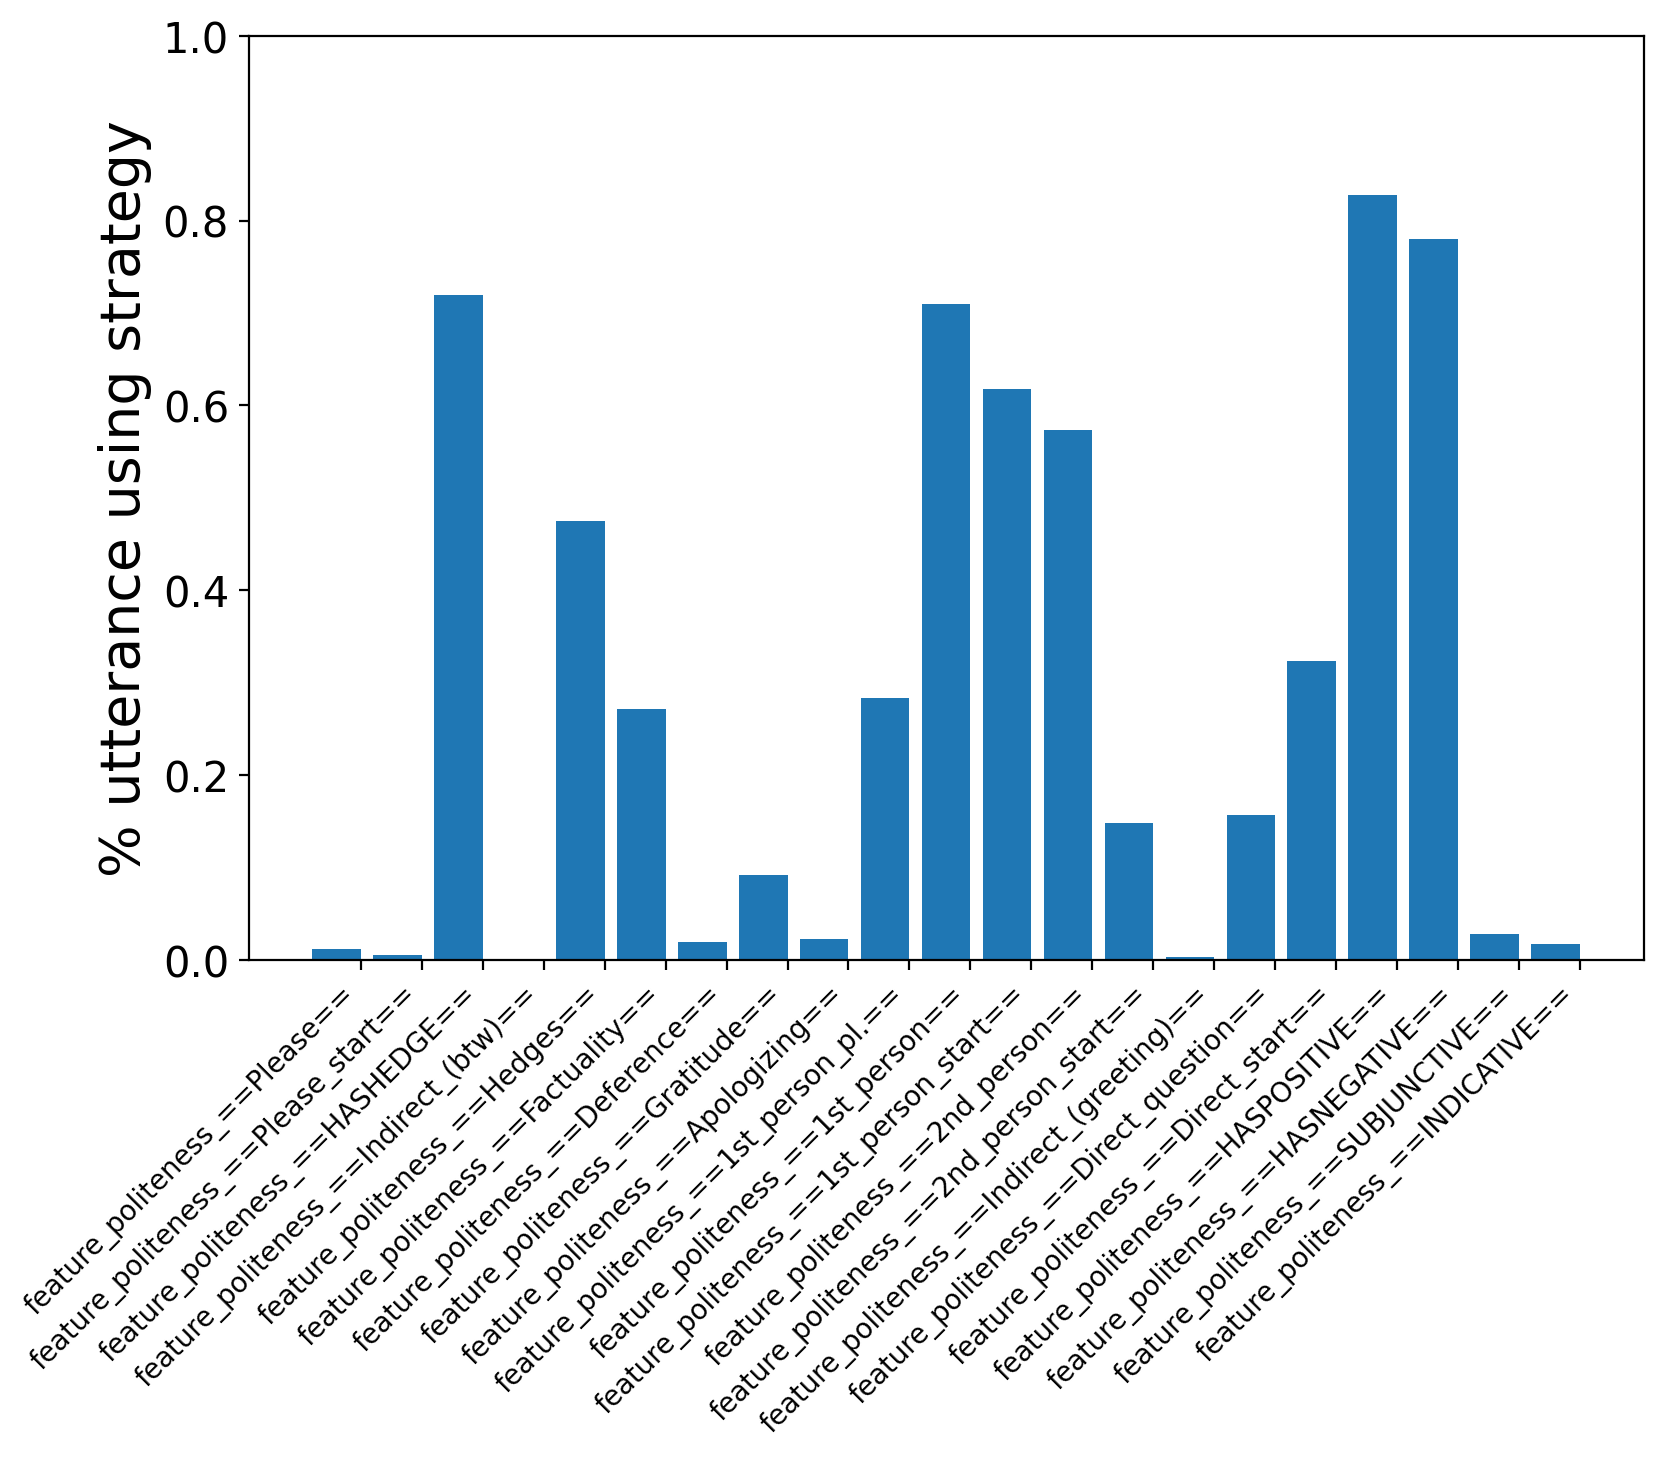

In [40]:
unsuccessquery = lambda x : (not(x.speaker.id != corpus.get_utterance(x.conversation_id).speaker.id)
and x.meta["success"] == 0)
unsuccess_data = ps.summarize(fullparsed, unsuccessquery, plot = True, y_lim = 1)

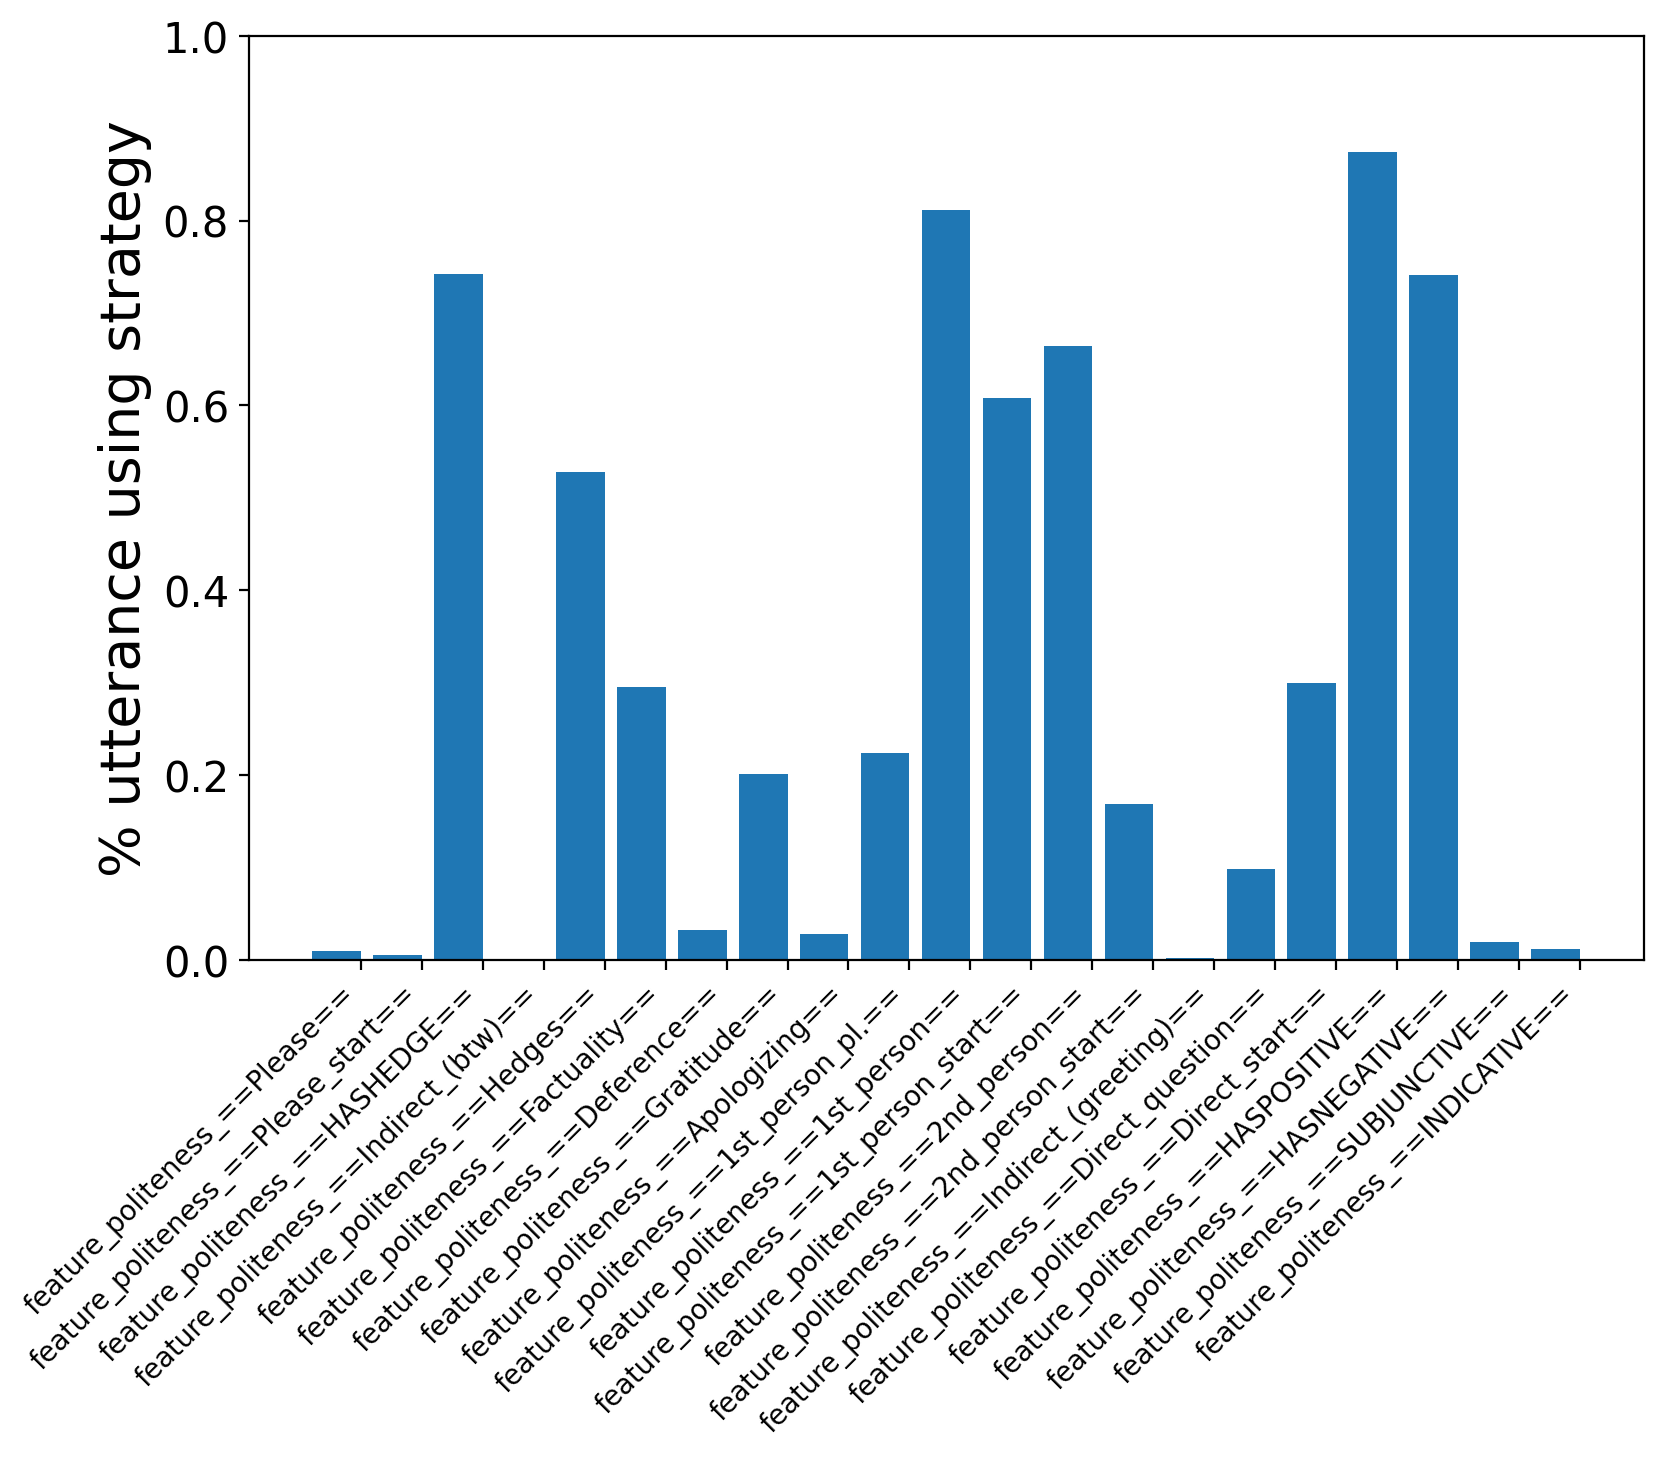

In [42]:
successquery = lambda x : (not(x.speaker.id != corpus.get_utterance(x.conversation_id).speaker.id)
and x.meta["success"] == 1)
success_data = ps.summarize(fullparsed, successquery, plot = True, y_lim = 1)

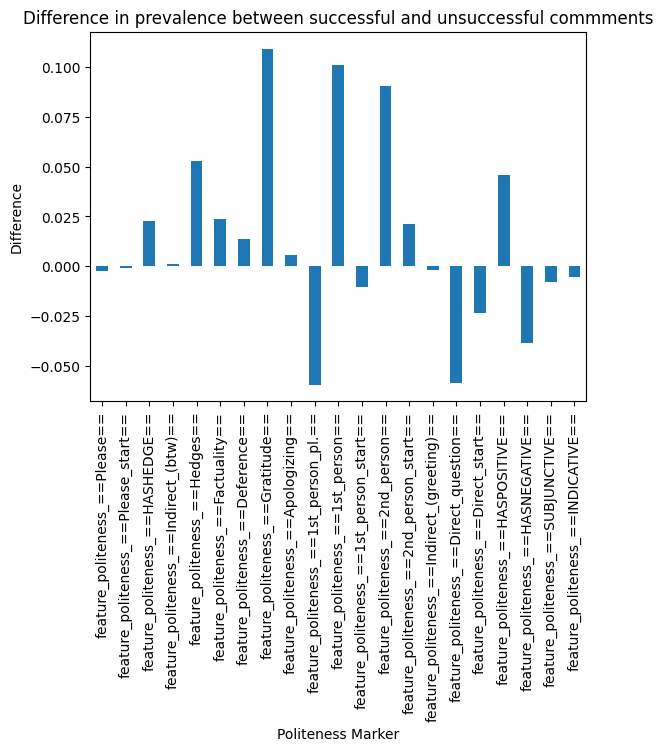

feature_politeness_==Please==                -0.003
feature_politeness_==Please_start==          -0.001
feature_politeness_==HASHEDGE==               0.023
feature_politeness_==Indirect_(btw)==         0.001
feature_politeness_==Hedges==                 0.053
feature_politeness_==Factuality==             0.024
feature_politeness_==Deference==              0.014
feature_politeness_==Gratitude==              0.109
feature_politeness_==Apologizing==            0.006
feature_politeness_==1st_person_pl.==        -0.059
feature_politeness_==1st_person==             0.101
feature_politeness_==1st_person_start==      -0.011
feature_politeness_==2nd_person==             0.091
feature_politeness_==2nd_person_start==       0.021
feature_politeness_==Indirect_(greeting)==   -0.002
feature_politeness_==Direct_question==       -0.059
feature_politeness_==Direct_start==          -0.024
feature_politeness_==HASPOSITIVE==            0.046
feature_politeness_==HASNEGATIVE==           -0.039
feature_poli

In [56]:
s_us_diffs = success_data - unsuccess_data
s_us_diffs.plot(kind='bar', title='Difference in prevalence between successful and unsuccessful commments', ylabel='Difference')
plt.xlabel('Politeness Marker')
plt.show()

print(round(s_us_diffs, 3))

In [ ]:
from collections import Counter
import spacy
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_trf')
matcher = Matcher(nlp.vocab)

passive_rules = [
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBN'}],
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBZ'}],
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'RB'}, {'TAG': 'VBN'}],
]
active_rules = [
    [{'DEP': 'nsubj'}, {'TAG': 'VBD', 'DEP': 'ROOT'}],
    [{'DEP': 'nsubj'}, {'TAG': 'VBP'}, {'TAG': 'VBG', 'OP': '!'}],
    [{'DEP': 'nsubj'}, {'DEP': 'aux', 'OP': '*'}, {'TAG': 'VB'}],
    [{'DEP': 'nsubj'}, {'DEP': 'aux', 'OP': '*'}, {'TAG': 'VBG'}],
    [{'DEP': 'nsubj'}, {'TAG': 'RB', 'OP': '*'}, {'TAG': 'VBG'}],
    [{'DEP': 'nsubj'}, {'TAG': 'RB', 'OP': '*'}, {'TAG': 'VBZ'}],
    [{'DEP': 'nsubj'}, {'TAG': 'RB', 'OP': '+'}, {'TAG': 'VBD'}],
]

matcher.add('Passive', passive_rules)
matcher.add('Active', active_rules)

p_ratios_successful = []
p_ratios_unsuccessful = []

for utt in utts:
    if utt.conversation_id != utt.id and utt.speaker.id != corpus.get_utterance(utt.conversation_id).speaker.id:
        doc = nlp(utt.text)
        matches = matcher(doc)

        counts = Counter()
        seen_types = set()  # ensure one match type per sentence
        for match_id, _, _ in matches:
            string_id = nlp.vocab.strings[match_id]
            if string_id not in seen_types:
                counts[string_id] += 1
                seen_types.add(string_id)

        passive = counts['Passive']
        active = counts['Active']
        total = passive + active
        passive_ratio = passive / total if total > 0 else 0

        if utt.meta["success"] == 1:
            p_ratios_successful.append({"ratio": passive_ratio})
        if utt.meta["success"] == 0:
            p_ratios_unsuccessful.append({"ratio": passive_ratio})